<a href="https://colab.research.google.com/github/Esther-Wagatwe/EASY-ML/blob/master/Fruit_Classification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fruit Classification with CNN (Apples vs Pears)

This notebook trains a CNN to classify fruit images as either apples or pears using PyTorch. It checks for local data first and handles extraction.

## 1. Import Required Libraries

In [ ]:
import os
import gdown
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

## 2. Download and Extract Dataset

In [ ]:
## PLEASE DON'T MODIFY THIS CELL

# Paths and file ID
dataset_folder = "/content/fruits_dataset"
zip_path = "/content/fruits_dataset.zip"
file_id = "153Z20lsYzdpKHlFSrRlBWsSJNaXhcl6a"

# Download only if zip not already present
if not os.path.exists(zip_path):
    print("Downloading dataset...")
    gdown.download(id=file_id, output=zip_path, fuzzy=True)
else:
    print("Zip file already exists. Skipping download.")

# Extract only if fruits_dataset/ does not already exist
if not os.path.exists(dataset_folder):
    print("Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")
else:
    print("Dataset already extracted.")

# Move apples and pears into fruits_dataset/ if they exist directly under /content
for folder in ["apples", "pears", "Pears"]:
    src = f"/content/{folder}"
    dst = f"/content/fruits_dataset/{folder.lower()}"
    if os.path.exists(src) and not os.path.exists(dst):
        os.makedirs("/content/fruits_dataset", exist_ok=True)
        os.rename(src, dst)

# Confirm class folders
print("Available classes:", os.listdir("/content/fruits_dataset"))


Downloading...
From (original): https://drive.google.com/uc?id=153Z20lsYzdpKHlFSrRlBWsSJNaXhcl6a
From (redirected): https://drive.google.com/uc?id=153Z20lsYzdpKHlFSrRlBWsSJNaXhcl6a&confirm=t&uuid=005267da-6f3f-42a6-a71f-5509a7b18619
To: /content/fruits_dataset.zip
100%|██████████| 34.4M/34.4M [00:00<00:00, 51.9MB/s]


Extracting dataset...
Available classes: ['apples', 'pears']


## 3. Prepare Dataset

In [ ]:
data_dir = '/content/fruits_dataset'
class_folder = os.listdir(data_dir)
num_classes = len(class_folder)
print(f"Number of classes: {num_classes}")
print(f"Class folders: {class_folder}")

Number of classes: 2
Class folders: ['apples', 'pears']


In [ ]:
# Prepare dataset
data_dir = '/content/fruits_dataset'

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

# Load the dataset using ImageFolder
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.80 * len(full_dataset)) # Using 85% for training
val_size = len(full_dataset) - train_size # Using remaining 15% for validation

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 250
Number of validation samples: 63


## 4. Visualize the dataset

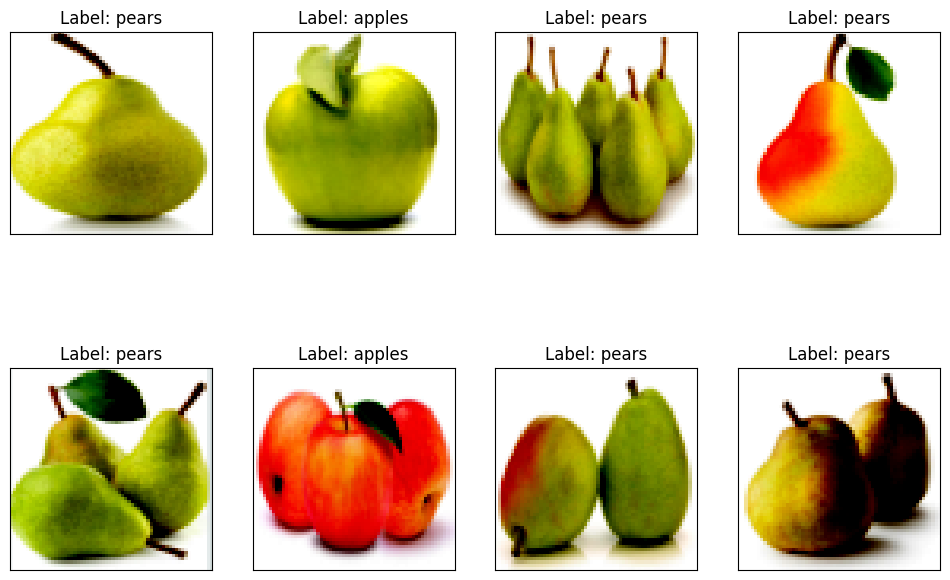

In [ ]:
# Get a batch of training data
images, labels = next(iter(train_loader))

# Denormalize the images (if normalization was applied - which it wasn't in this case, but good practice)
# If you had normalization, you would reverse it here.

# Display images
fig = plt.figure(figsize=(12, 8))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    # Convert image to numpy array and transpose dimensions for matplotlib (C, H, W) -> (H, W, C)
    plt.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax.set_title(f"Label: {full_dataset.classes[labels[i]]}")
plt.show()

## 5. Define CNN Model

In [ ]:
class FruitClassifier(nn.Module):
    def __init__(self, num_classes):
        super(FruitClassifier, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16) # Add Batch Normalization after conv1
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32) # Add Batch Normalization after conv2
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Corrected calculation for the size of the flattened layer
        # Input size: 64x64
        # After conv1 (3x3, p=1): 64x64
        # After pool (2x2, s=2): 32x32
        # After conv2 (3x3, p=1): 32x32
        # After pool (2x2, s=2): 16x16
        # Number of channels after conv2: 32
        self.fc1 = nn.Linear(32 * 32 * 32, 128)

        self.dropout = nn.Dropout(0.5) # Add Dropout layer

        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, num_classes)


    def forward(self, x):
        # Define the forward pass of the network.
        # Input x is the image tensor.
        x = self.conv1(x) # Apply the first convolution.
        x = self.bn1(x) # Apply Batch Normalization
        x = self.relu1(x) # Apply the first ReLU activation.
        x = self.conv2(x) # Apply the second convolution.
        x = self.bn2(x) # Apply Batch Normalization
        x = self.relu2(x) # Apply the second ReLU activation.
        x = self.pool(x) # Apply the Max pooling layer.
        # print(x.shape)
        x = torch.flatten(x, 1)

        x = self.fc1(x) # Apply the first fully connected layer.
        x = self.dropout(x) # Apply Dropout
        x = self.fc2(x) # Apply the second fully connected layer.
        return self.output(x)

In [ ]:
#  !pip install torchinfo

In [ ]:
from torchinfo import summary
# Setup model and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FruitClassifier(2).to(device)

#  Print detailed model summary
print(summary(
    model,
    input_size=(1, 3, 64, 64),     # Batch size 1, 3 channels, 64x64 input to match model expectation
    col_names=["input_size", "output_size", "num_params", "kernel_size", "mult_adds"],
    col_width=28,
    row_settings=["depth", "var_names"],
    device=device.type,
    verbose=2
))

Layer (type (var_name):depth-idx)        Input Shape                  Output Shape                 Param #                      Kernel Shape                 Mult-Adds
FruitClassifier (FruitClassifier)        [1, 3, 64, 64]               [1, 2]                       --                           --                           --
├─Conv2d (conv1): 1-1                    [1, 3, 64, 64]               [1, 16, 64, 64]              448                          [3, 3]                       1,835,008
│    └─weight                                                                                      ├─432                        [3, 16, 3, 3]
│    └─bias                                                                                        └─16                         [16]
├─BatchNorm2d (bn1): 1-2                 [1, 16, 64, 64]              [1, 16, 64, 64]              32                           --                           32
│    └─weight                                                          

## 6. Training Setup

## 7. Train the Model

In [ ]:
from sklearn.metrics import accuracy_score # Import the accuracy_score function from scikit-learn
loss_fn = nn.CrossEntropyLoss() # Define the loss function as Cross-Entropy Loss, commonly used for classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # Define the optimizer as Adam, with a learning rate of 0.01. It will update the model's parameters.


# Training and testing loop
epochs = 10 # Define the number of training epochs
for epoch in range(epochs): # Loop through each epoch
    for X_train, y_train in train_loader : # Iterate through batches of training data
        model.train() # Set the model to training mode (enables dropout, batch normalization, etc.)
        X_train, y_train = X_train.to(device), y_train.to(device) # Move data to the appropriate device (CPU or GPU)
        outputs = model(X_train) # Perform a forward pass to get model outputs (predictions)
        loss = loss_fn(outputs, y_train) # Calculate the loss between the model outputs and the true labels

        optimizer.zero_grad() # Zero the gradients of the optimizer
        loss.backward() # Perform backpropagation to calculate gradients
        optimizer.step() # Update the model's parameters based on the calculated gradients

    model.eval() # Set the model to evaluation mode (disables dropout, batch normalization, etc.)
    all_preds = [] # Initialize an empty list to store all predictions
    all_labels = [] # Initialize an empty list to store all true labels
    with torch.inference_mode(): # Disable gradient calculation for inference
        for X_test, y_test in val_loader: # Iterate through batches of validation data
            X_test, y_test = X_test.to(device), y_test.to(device) # Move data to the appropriate device (CPU or GPU)
            test_preds = model(X_test) # Perform a forward pass to get model predictions on validation data
            test_pred_labels = torch.argmax(test_preds, dim=1) # Get the predicted class label by finding the index of the maximum logit

            all_preds.append(test_pred_labels.cpu()) # Append the predicted labels to the list (move to CPU if on GPU)
            all_labels.append(y_test.cpu()) # Append the true labels to the list (move to CPU if on GPU)

    # Concaténer toutes les prédictions et labels
    all_preds = torch.cat(all_preds) # Concatenate all predicted labels into a single tensor
    all_labels = torch.cat(all_labels) # Concatenate all true labels into a single tensor
    acc = accuracy_score(all_labels, all_preds) # Calculate the accuracy score
    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f} | Validation Accuracy: {acc:.4f}") # Print the epoch number, training loss, and validation accuracy

Epoch 1/10 | Loss: 96.8376 | Validation Accuracy: 0.4286
Epoch 2/10 | Loss: 11.2949 | Validation Accuracy: 0.4286
Epoch 3/10 | Loss: 7.9012 | Validation Accuracy: 0.4762
Epoch 4/10 | Loss: 0.7233 | Validation Accuracy: 0.7302
Epoch 5/10 | Loss: 2.3472 | Validation Accuracy: 0.6825
Epoch 6/10 | Loss: 8.9171 | Validation Accuracy: 0.7619
Epoch 7/10 | Loss: 2.1328 | Validation Accuracy: 0.7143
Epoch 8/10 | Loss: 1.3879 | Validation Accuracy: 0.6984
Epoch 9/10 | Loss: 1.2280 | Validation Accuracy: 0.7460
Epoch 10/10 | Loss: 1.2756 | Validation Accuracy: 0.7937


## 8. Evaluate the Model

In [ ]:
#Write your code here

Final Validation Accuracy: 0.7937
Precision: 0.7692
Recall: 0.7407
F1-Score: 0.7547


## 9. Visualize Predictions

Visualize the model's predictions on a batch of validation data, displaying the images along with their true and predicted labels.

## Get a batch of data

### Subtask:
Retrieve a batch of images and labels from the validation data loader.


**Reasoning**:
Retrieve a batch of images and labels from the validation data loader using `next(iter(val_loader))`.



In [ ]:
# Get a batch of validation data
images, labels = next(iter(val_loader))

## Make predictions

### Subtask:
Pass the batch of images through the trained model to get predictions.


**Reasoning**:
Pass the batch of images through the trained model to get predictions as instructed.



In [ ]:
# Move images to the correct device
images = images.to(device)

# Set the model to evaluation mode
model.eval()

# Get predictions (disable gradient calculations)
with torch.no_grad():
    predictions = model(images)

## Convert predictions to labels

### Subtask:
Convert the model's output (logits) into predicted class labels.


**Reasoning**:
Convert the raw model predictions (logits) from the device to CPU and then find the predicted class labels by taking the argmax.



In [ ]:
# Move predictions back to CPU
predictions_cpu = predictions.cpu()

# Get predicted class labels
predicted_labels = torch.argmax(predictions_cpu, dim=1)

## Visualize images and labels

### Subtask:
Visualize the images from the validation batch along with their true and predicted labels.


**Reasoning**:
Visualize the images from the validation batch along with their true and predicted labels.



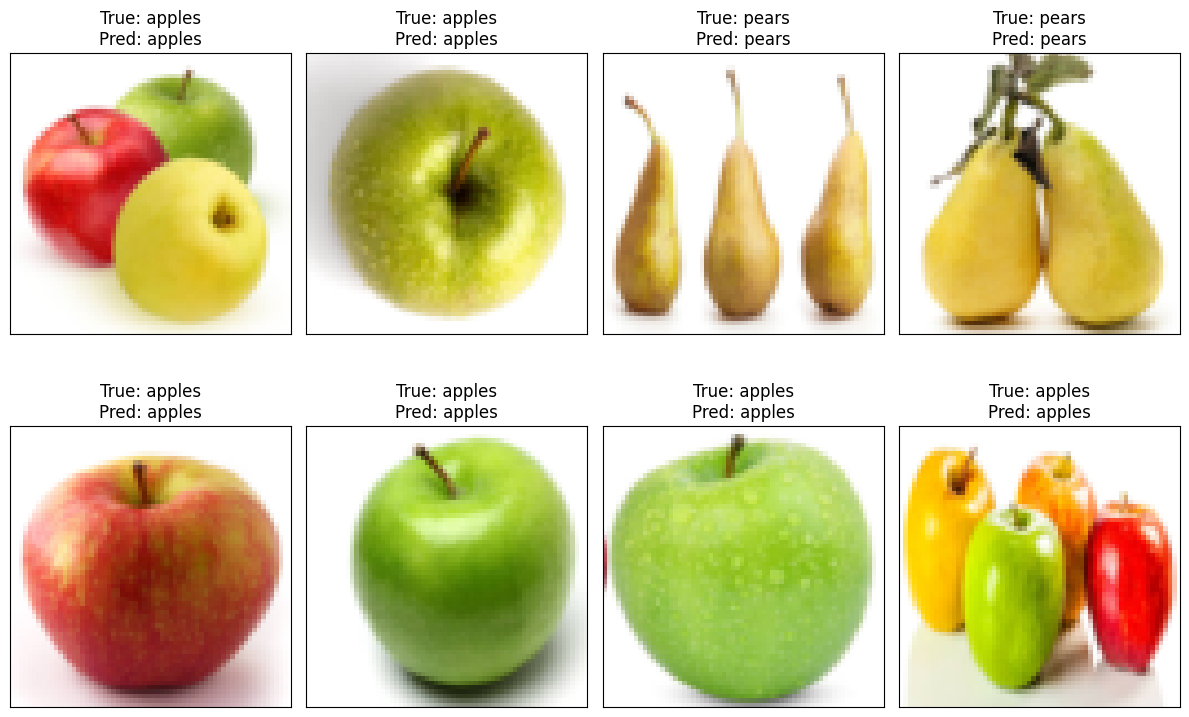

In [ ]:
# Display images with true and predicted labels
fig = plt.figure(figsize=(12, 8))
for i in range(min(len(images), 8)): # Display up to 8 images
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    # Denormalize and convert image to numpy array and transpose dimensions for matplotlib
    # Reverse the normalization: (image * std) + mean. Our std and mean are 0.5, 0.5
    img = images[i].cpu().numpy().transpose((1, 2, 0)) * 0.5 + 0.5
    img = np.clip(img, 0, 1) # Clip values to be within [0, 1] for correct display

    plt.imshow(img)
    ax.set_title(f"True: {full_dataset.classes[labels[i]]}\nPred: {full_dataset.classes[predicted_labels[i]]}")
plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

*   A batch of images and labels was successfully retrieved from the validation data loader.
*   The retrieved images were passed through the trained model to obtain predictions.
*   The model's output (logits) were converted into predicted class labels by selecting the class with the highest probability.
*   A figure displaying up to 8 images from the batch was generated, with each image showing its true label and the model's predicted label in the title.
*   The images were correctly denormalized and formatted for display using Matplotlib.

### Insights or Next Steps

*   The visualization provides a qualitative assessment of the model's performance on individual examples.
*   Further analysis could involve calculating quantitative metrics (e.g., accuracy, precision, recall) on a larger portion or the entire validation dataset to get a more comprehensive understanding of the model's performance.
